In [24]:
from pathlib import Path
import sys

PATH_FOR_PROJECT = str(Path().resolve().parent)
sys.path.append(PATH_FOR_PROJECT)

In [25]:
from tqdm import tqdm

In [26]:
from uncertainty_forecasting.models.training_tools.early_stopping import EarlyStopping
from dataclasses import dataclass

@dataclass
class ExperimentParameters:

    path: str = "/"
    version: str = "v0.0.4"
    show_figures: bool = True
    smoke_test: bool = False
    train_lstm: bool = True
    save_lstm: bool = False
    type_of_data: str = "sinus"
    name: str = "feature_extractor"

In [27]:
PATH_LOCAL = "models/"

In [28]:
early_stopper = EarlyStopping(patience=4, verbose=True)

experiment_params = ExperimentParameters()
experiment_params.path = PATH_FOR_PROJECT + "/examples/.models/"
experiment_params.version = "v0.0.7"
experiment_params.show_figures = False
experiment_params.smoke_test = False
experiment_params.train_lstm = True
experiment_params.save_lstm = True
experiment_params.type_of_data = "autoregressive-5" # options are sin or "autoregressive-5"
experiment_params.name = "feature_extractor_" + experiment_params.type_of_data

In [29]:
n_data = 1000
length_of_sequences = 7 + 1

# 2. Data generation

In [30]:
from math import floor

In [31]:
from uncertainty_forecasting.data_generation.data_generators_switcher import DatageneratorsSwitcher
from uncertainty_forecasting.data_handling.data_reshaping import reshape_data_for_LSTM, reshape_into_sequences
from uncertainty_forecasting.visualisations.visualisations import Visualisator

In [32]:
size_of_training_set = 0.5
size_of_training_and_val_set = 0.7

In [33]:
data_generator = DatageneratorsSwitcher(experiment_params.type_of_data)
data = data_generator(n_data)

sequences = reshape_into_sequences(data, length_of_sequences)
all_data = reshape_data_for_LSTM(sequences)

training_data_labels = all_data[length_of_sequences-1, :, 0]

number_of_train_data = floor(size_of_training_set*n_data)
val_set_end = floor(size_of_training_and_val_set*n_data)

data_train = all_data[:, :number_of_train_data, :]
data_validation = all_data[:, number_of_train_data:val_set_end, :]

if experiment_params.show_figures:
    Visualisator.show_time_series(data=all_data[length_of_sequences-2, :, 0],
                                  title="Data generated using an ARMA(4,2) process")

# 3. Training of the feature extractor (LSTM)

In [34]:
from uncertainty_forecasting.models.lstm_params import LSTM_parameters
from uncertainty_forecasting.models.regression.LSTM_BayesRegressor.LSTM import LSTM

In [35]:
from uncertainty_forecasting.models.model_data_feeder import *
from uncertainty_forecasting.models.disk_reader_and_writer import save_checkpoint, load_checkpoint

In [36]:
from sklearn.metrics import mean_squared_error

In [37]:
lstm_params = LSTM_parameters()

if experiment_params.train_lstm is False:
    lstm_params.load("lstm_params_" + experiment_params.name + "_" + experiment_params.version, experiment_params.path)
    
lstm_params.batch_size = 50
lstm_params.hidden_dim = 5
lstm_params.dropout = 0.4

In [38]:
learning_rate = 1e-3
num_epochs = 2300 if not experiment_params.smoke_test else 1
epoch_interval_for_loss_tracking =100

In [39]:
model = LSTM(lstm_params)
model.cuda()

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (lstm): LSTM(1, 5, dropout=0.4)
  (linear): Linear(in_features=5, out_features=1, bias=True)
)

In [40]:
loss_fn = torch.nn.MSELoss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate)

/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [41]:
if experiment_params.train_lstm:
    hist = np.zeros(num_epochs)
    for epoch in tqdm(range(num_epochs)):
        model.hidden = model.init_hidden()

        losses, N_data = make_forward_pass(data_loader_sequences, model, loss_fn, data_train, lstm_params.batch_size)

        if epoch % epoch_interval_for_loss_tracking == 0:
            y_pred, y_true = make_predictions(data_loader_sequences, model, data_validation, lstm_params.batch_size)
            val_loss = mean_squared_error(y_pred, y_true)
            print("Epoch ", epoch, "MSE: ", val_loss)
            early_stopper(epoch, val_loss, model)

            if early_stopper.early_stop:
                break

        hist[epoch] = losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
else:

    load_checkpoint(model, optimizer, experiment_params.path,
                    experiment_params.name + "_" + experiment_params.version)

if experiment_params.save_lstm:
    save_checkpoint(model, optimizer, experiment_params.path,
                    experiment_params.name + "_" + experiment_params.version)
    lstm_params.save(experiment_params.version, experiment_params.path)

y_pred, _ = make_predictions(data_loader_sequences, model, all_data, lstm_params.batch_size)
features, y_true = extract_features(data_loader_sequences, model, all_data, lstm_params.batch_size)

  1%|          | 13/2300 [00:00<00:41, 55.01it/s]

Epoch  0 MSE:  0.230709


  5%|▌         | 115/2300 [00:01<00:30, 71.85it/s]

Epoch  100 MSE:  0.0868583


  9%|▉         | 211/2300 [00:02<00:28, 73.83it/s]

Epoch  200 MSE:  0.0733921


 13%|█▎        | 310/2300 [00:04<00:30, 64.31it/s]

Epoch  300 MSE:  0.0683073


 18%|█▊        | 410/2300 [00:06<00:35, 53.17it/s]

Epoch  400 MSE:  0.0638682


 22%|██▏       | 507/2300 [00:08<00:33, 53.35it/s]

Epoch  500 MSE:  0.0599093


 27%|██▋       | 610/2300 [00:09<00:24, 69.18it/s]

Epoch  600 MSE:  0.0556001


 31%|███       | 709/2300 [00:11<00:24, 65.73it/s]

Epoch  700 MSE:  0.0530051


 35%|███▌      | 810/2300 [00:13<00:24, 61.94it/s]

Epoch  800 MSE:  0.0532726
EarlyStopping counter: 1 out of 4


 39%|███▉      | 906/2300 [00:15<00:33, 41.28it/s]

Epoch  900 MSE:  0.0536513
EarlyStopping counter: 2 out of 4


 44%|████▍     | 1007/2300 [00:16<00:21, 60.36it/s]

Epoch  1000 MSE:  0.0536952
EarlyStopping counter: 3 out of 4


 48%|████▊     | 1093/2300 [00:17<00:17, 68.02it/s]

Epoch  1100 MSE:  0.0536386
EarlyStopping counter: 4 out of 4
Validation loss decreased (inf --> 0.053639).  Saving model ...


# 4. Results of feature extractor

In [42]:
from sklearn.metrics import r2_score

In [43]:
print("r2 score: %.4f" % r2_score(y_true.flatten(), y_pred.flatten()))
print("r2 score for naive forecaster: %.4f" % r2_score(y_true[1:].flatten(), y_true[:-1].flatten()))

r2 score: 0.5225
r2 score for naive forecaster: 0.3473


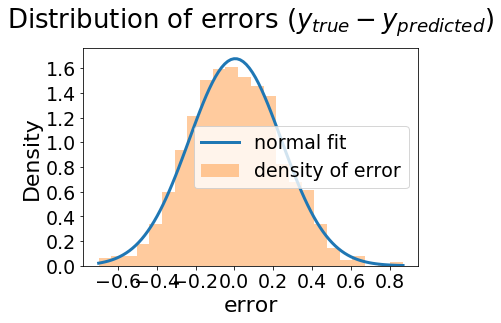

In [44]:
errors = y_true.flatten() - y_pred.flatten()

Visualisator.show_distribution(data=errors,
                               title="Distribution of errors ($y_{true} - y_{predicted}$)",
                               normal_fit=True,
                               name="error")

In [45]:
if experiment_params.show_figures:
    Visualisator.show_predictions(y_pred, y_true)

    if experiment_params.train_lstm:
        Visualisator.show_epoch_convergence(data=hist,
                                            name="Loss",
                                            title="Loss convergence curve for the LSTM training")


# 5. Probabilistic model

In [46]:
from uncertainty_forecasting.models.regression.LSTM_BayesRegressor.bayesian_linear_regression.bayesian_linear_regression import BayesianLinearModel

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_wbbinuxn.c:4:10: fatal error: cudnn.h: No such file or directory\n #include <cudnn.h>\n          ^~~~~~~~~\ncompilation terminated.\n'
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 227, in <module>
    use(config.device)
  File "/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 214, in use
    init_dev(device, preallocate=preallocate)
  File "/home/louis/anaconda3/envs/env_UncertaintyForecasting/lib/python3.6/site-packages/theano/gpuarray/__init__.py", line 140, in init_dev
    context.free_gmem / MB))
RuntimeError: Trying to preallocate 3843 MB of GPU memory while only 3148 MB are available.


In [ ]:
number_of_train_data = floor(size_of_training_and_val_set*n_data)
X_train, X_test, y_train, y_test = features[:number_of_train_data], features[number_of_train_data:], \
                                   y_true[:number_of_train_data], y_true[number_of_train_data:]

model.cpu()
priors_beta, _ = model.last_layers_weights

model_linear_mcmc = BayesianLinearModel(X_train,
                                        y_train,
                                        priors_beta,
                                        SMOKE_TEST=experiment_params.smoke_test)

model_linear_mcmc.option = "NUTS"
model_linear_mcmc.sample()
model_linear_mcmc.show_trace()

predictions = model_linear_mcmc.make_predictions(X_test, y_test)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, thetas, theta_0]

Sampling 4 chains:   1%|          | 506/44000 [00:15<27:26, 26.42draws/s]


Sampling 4 chains:   2%|▏         | 888/44000 [00:32<36:00, 19.95draws/s]


Sampling 4 chains:   3%|▎         | 1138/44000 [00:55<1:37:26,  7.33draws/s]


Sampling 4 chains:   3%|▎         | 1352/44000 [01:19<1:19:30,  8.94draws/s]


Sampling 4 chains:   4%|▎         | 1582/44000 [01:42<1:13:30,  9.62draws/s]


Sampling 4 chains:   4%|▍         | 1794/44000 [02:06<1:30:51,  7.74draws/s]


Sampling 4 chains:   5%|▍         | 2009/44000 [02:29<1:52:01,  6.25draws/s]


Sampling 4 chains:   5%|▍         | 2188/44000 [02:53<1:01:58, 11.25draws/s]


Sampling 4 chains:   5%|▌         | 2380/44000 [03:16<1:21:03,  8.56draws/s]


Sampling 4 chains:   6%|▌         | 2590/44000 [03:40<1:04:58, 10.62draws/s]


Sampling 4 chains:   6%|▋         | 2800/44000 [04:03<1:07:22, 10.19draws/s]


Sampling 4 chains:   7%|▋         | 3001/44000 [04:25<1:37:14,  7.03draws/s]


Sampling 4 chains:   7%|▋         | 3200/44000 [04:48<2:08:10,  5.31draws/s]


Sampling 4 chains:   8%|▊         | 3410/44000 [05:11<1:23:19,  8.12draws/s]


Sampling 4 chains:   8%|▊         | 3619/44000 [05:35<1:33:04,  7.23draws/s]


Sampling 4 chains:   9%|▊         | 3824/44000 [05:59<1:34:19,  7.10draws/s]


Sampling 4 chains:   9%|▉         | 4017/44000 [06:21<1:40:35,  6.62draws/s]


Sampling 4 chains:  10%|▉         | 4221/44000 [06:45<1:33:12,  7.11draws/s]


Sampling 4 chains:  10%|█         | 4435/44000 [07:06<1:04:59, 10.15draws/s]


Sampling 4 chains:  11%|█         | 4649/44000 [07:28<1:45:48,  6.20draws/s]


Sampling 4 chains:  11%|█         | 4845/44000 [07:51<1:13:25,  8.89draws/s]


Sampling 4 chains:  11%|█▏        | 5044/44000 [08:13<1:31:48,  7.07draws/s]


Sampling 4 chains:  12%|█▏        | 5250/44000 [08:37<1:12:58,  8.85draws/s]


Sampling 4 chains:  12%|█▏        | 5449/44000 [08:59<1:12:45,  8.83draws/s]


Sampling 4 chains:  13%|█▎        | 5661/44000 [09:25<1:35:00,  6.73draws/s]


Sampling 4 chains:  13%|█▎        | 5859/44000 [09:47<1:25:15,  7.46draws/s]


Sampling 4 chains:  14%|█▍        | 6060/44000 [10:10<56:34, 11.18draws/s]


Sampling 4 chains:  14%|█▍        | 6280/44000 [10:33<1:07:38,  9.29draws/s]


Sampling 4 chains:  15%|█▍        | 6489/44000 [10:56<1:22:15,  7.60draws/s]


Sampling 4 chains:  15%|█▌        | 6697/44000 [11:19<49:38, 12.52draws/s]


Sampling 4 chains:  16%|█▌        | 6910/44000 [11:42<1:10:28,  8.77draws/s]


Sampling 4 chains:  16%|█▌        | 7125/44000 [12:06<1:16:50,  8.00draws/s]


Sampling 4 chains:  17%|█▋        | 7337/44000 [12:29<1:10:38,  8.65draws/s]


Sampling 4 chains:  17%|█▋        | 7515/44000 [12:47<59:41, 10.19draws/s]

# 6. Analysis of probabilistic predictions

In [ ]:
from uncertainty_forecasting.models.calibration.analysis import show_analysis
from uncertainty_forecasting.models.calibration.diagnostics import *

In [ ]:
deviation_score_probabilistic_calibration = calculate_confidence_interval_calibration(predictions.values, predictions.true_values)
deviation_score_exceedance_calibration = calculate_one_sided_cumulative_calibration(predictions.values, predictions.true_values)
deviation_score_marginal_calibration = calculate_marginal_calibration(predictions.values, predictions.true_values)

predictions.train_data = y_train
predictions.show_predictions_with_training_data(confidence_interval=0.95)

show_analysis(predictions.values, predictions.true_values, name="LSTM + " + model_linear_mcmc.option)